In [14]:
# torchfactor imports
from torchfactor.factorization.svdnet import SVDNet
from torchfactor.experiment.experiment import Experiment

# dataset import
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from polyu_dataset import PolyUDataset

# other imports
import torch
import numpy as np

In [15]:
IMAGE_TYPE = "real"
TRAIN_BATCH_SIZE = 1
VAL_BATCH_SIZE = 1

training_dataset = PolyUDataset(split_type="train", image_type=IMAGE_TYPE, downsample_shape=(256,256))
training_dataloader = torch.utils.data.DataLoader(
    training_dataset, batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, num_workers=0, drop_last=True
)

validation_dataset = PolyUDataset(split_type='val', image_type=IMAGE_TYPE, in_memory=False, downsample_shape=(256,256))
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=VAL_BATCH_SIZE,
    shuffle=False, num_workers=0, drop_last=False
)

In [16]:
# SVDNet as the full network for factorization can only learn a single image
indices = [np.random.randint(len(training_dataset))] # randomly select a single image

single_ele_dataloader = torch.utils.data.DataLoader(
    training_dataset, batch_size=TRAIN_BATCH_SIZE, 
    num_workers=0, drop_last=False,
    sampler=torch.utils.data.SubsetRandomSampler(indices)
)

In [18]:
# SVDNet learning to factor a single image
net = SVDNet(256, 256)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-1)

def loss(x, x_hat):
    return ((x - x_hat)**2).sum()

experiment = Experiment(
    net=net, loss=loss, optimizer=optimizer,
    train_dataloader=single_ele_dataloader, validation_dataloader=single_ele_dataloader,
    use_eye_as_net_input=True, inputs_are_ground_truth=True, has_labels=False
)

train_loss_over_epochs, val_loss_over_epochs, _ = experiment.run(train_epochs=1000, train_validation_interval=100)

epoch 100: total loss is 7150.884247542209, avg loss is 7150.884247542209
epoch 100: val avg loss is 7059.75121659182
epoch 200: total loss is 2133.0903413758588, avg loss is 2133.0903413758588
epoch 200: val avg loss is 2105.379441732517
epoch 300: total loss is 625.8802913353028, avg loss is 625.8802913353028
epoch 300: val avg loss is 622.0356184958263
epoch 400: total loss is 196.9364385617774, avg loss is 196.9364385617774
epoch 400: val avg loss is 192.9027916825586
epoch 500: total loss is 100.65486287241905, avg loss is 100.65486287241905
epoch 500: val avg loss is 100.07726353884098
epoch 600: total loss is 95.69592221010974, avg loss is 95.69592221010974
epoch 600: val avg loss is 93.48588677308331
epoch 700: total loss is 97.00836880567246, avg loss is 97.00836880567246
epoch 700: val avg loss is 91.88584369163317
epoch 800: total loss is 89.70516744396278, avg loss is 89.70516744396278
epoch 800: val avg loss is 89.44063539258485
epoch 900: total loss is 67.80564002153005, 

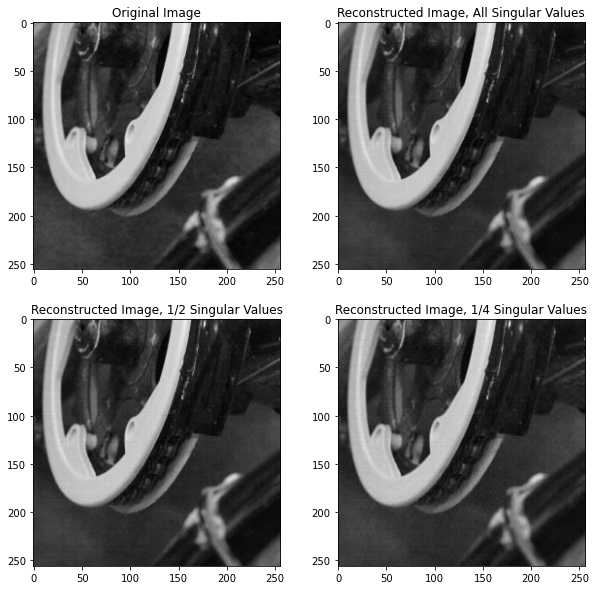

In [43]:
image_tensor = training_dataset[indices[0]]
U, S, VT = net.get_USVT(image_tensor.device)

# U, S, and VT are not sorted, argsort first
S = np.diag(S)
sorted_indices = np.argsort(S)[::-1]
U = U[:,sorted_indices]
S = S[sorted_indices]
VT = VT[sorted_indices,:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Reconstruct image from learned SVD
recons = U @ np.diag(S) @ VT

# Compress image by keeping only most significant singular values
one_fourth_U = U[:,:64] # Remove columns
one_fourth_sigma = np.diag(S[:64]) # Remove rows and columns
one_fourth_VT = VT[:64,:] # Remove rows
one_fourth_recons = one_fourth_U @ one_fourth_sigma @ one_fourth_VT

half_U = U[:,:128] # Remove columns
half_sigma = np.diag(S[:128]) # Remove rows and columns
half_VT = VT[:128,:] # Remove rows
half_recons = half_U @ half_sigma @ half_VT

ax[0,0].set_title("Original Image")
ax[0,0].imshow(image_tensor[0], cmap='gray')
ax[0,1].set_title("Reconstructed Image, All Singular Values")
ax[0,1].imshow(recons, cmap='gray')
ax[1,0].set_title("Reconstructed Image, 1/2 Singular Values")
ax[1,0].imshow(half_recons, cmap='gray')
ax[1,1].set_title("Reconstructed Image, 1/4 Singular Values")
ax[1,1].imshow(one_fourth_recons, cmap='gray')
plt.show()